# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ __(5 pts)__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ __(bonus: 5 pts each)__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params), show graphs for different params
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. 
* 20-neuron network is probably not enough, feel free to experiment.

# Настройка jupyter

Я немного пошаманил, и сделал так, чтобы было проще прогать в jupyter notebook (cells 1-3), но не очень уверен, что это будет работать не только локально

In [1]:
# !pip install swig
# !pip install ufal.pybox2d
# !pip install gym[box2d]

In [2]:
# !pip install jupyter_contrib_nbextensions


In [3]:
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable C:\Users\vinik\Githubik\ml-homework

### Начало 

In [4]:
# setup

import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from gym.envs import box2d
%matplotlib inline
env = gym.make("LunarLander-v2").env #choose 1 env - for example: gym.make("MountainCar-v0").env
env.reset()
n_actions = env.action_space.n
print(n_actions)

4


In [5]:
def generate_session(agent, t_max=5000):
    
    states,actions = [], []
    total_reward = 0
    
    state = env.reset()[0]
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([state])
        probs = np.reshape(probs, (-1))
        
        action = np.random.choice(np.arange(n_actions), p=probs)
        
        x = env.step(action)
        
        new_state = x[0]
        reward = x[1]
        done = x[2];
        
        #record sessions like you did before
        
        states.append(state)
        
        actions.append(action)
        
        total_reward += reward
        
        state = new_state
        if done: 
            break
    return states, actions, total_reward  

In [6]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()[0]]*n_actions,range(n_actions));

C:\Users\vinik\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    rewards_batch = np.array(rewards_batch)
    
    n_session = len(states_batch)
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    ind = np.arange(n_session)
    
    ind = ind[rewards_batch[ind] >= reward_threshold]
    
    elite_states = [states_batch[i] for i in ind]
    elite_actions = [actions_batch[i] for i in ind]
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions

In [8]:
from IPython.display import clear_output

# some stuff to show progress

def show_progress(rewards_batch,log, reward_range=[-5000,+5000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    #print(rewards_batch)
    reward_range=[-1010,+1010]
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()

## Добавление визуализации (just for fun)
Чтобы было веселее, я добавлю визуализацую lunar lander, и мы сможем посмотреть как на самом деле нейросеть управляет этим луноходом, который садится на поверхность луны :)

In [9]:
import matplotlib.pyplot as plt


def visualize(agent, t_max=10000):
    env_show = gym.make("LunarLander-v2", render_mode = "human")
    
    state = env_show.reset()[0]
    
    for t in range(t_max):
        env_show.render()
        
        #predict array of action probabilities
        probs = agent.predict_proba([state])
        probs = np.reshape(probs, (-1))
        
        action = np.random.choice(np.arange(n_actions), p=probs)
        
        x = env_show.step(action)
        
        new_state = x[0]
        done = x[2]
        
        state = new_state
        if done: 
            break
    
    
    env_show.close()

In [10]:
# визуализация собственно

# for i in range(10):
#     visualize(agent)

mean reward = 61.051, threshold=31.208


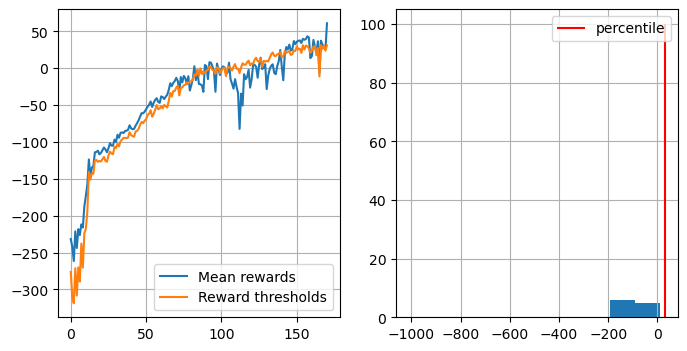

Time: 12226.85807299614
Win!
Time: 12226.85807299614


In [11]:
import time
n_sessions = 100
NeedMeanReward = 50

number_of_iterations = 200

percentile = 30
log = []
startTime = time.time()

def run():
    for i in range(number_of_iterations):
        #generate new sessions
        sessions = [generate_session(agent) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.fit(elite_states, elite_actions)

        show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

        print("Time:", time.time() - startTime)

        if(rewards_batch.mean() > NeedMeanReward):
            print("Win!")
            break

    print("Time:", time.time() - startTime)
    
run()

# Важный improve

Я попытался запустить исходный код без использования tips с percentile = 30, но модель обучалась так долго (3.3 часа блин), что можно было уснуть, глядя на это, поэтому я немного прочитал tips, и попытался понять как пофиксить.

<b>Важное улучшение</b> - откидывание ненужных игр с одинаковыми наградами, путем изменения rewards_batch >= reward_threshold на rewards_batch > reward_threshold

<b>Еще один забавный факт</b> - то, что модель, которая обучилась до mean_reward > 0, быстро садится между флажками на "площадку", но потом ничего не делает, так как condition of termination не выполняется, и получается так, что большую часть времени модель борется с ветром и все. 
 
Это влияет на скорость обучения, потому что, как только модель достигает mean_reward > 0, у нее почти все игры становятся именно такими, из-за чего одна итерация идет очень долго. Попробуем исправить это, сделав t_max = 2000.

In [11]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    rewards_batch = np.array(rewards_batch)
    
    n_session = len(states_batch)
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    ind = np.arange(n_session)
    
    ind = ind[rewards_batch[ind] > reward_threshold]
    
    elite_states = [states_batch[i] for i in ind]
    elite_actions = [actions_batch[i] for i in ind]
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions

In [12]:
def generate_session(agent, t_max=2000):
    
    states,actions = [], []
    total_reward = 0
    
    state = env.reset()[0]
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([state])
        probs = np.reshape(probs, (-1))
        
        action = np.random.choice(np.arange(n_actions), p=probs)
        
        x = env.step(action)
        
        new_state = x[0]
        reward = x[1]
        done = x[2];
        
        #record sessions like you did before
        
        states.append(state)
        
        actions.append(action)
        
        total_reward += reward
        
        state = new_state
        if done: 
            break
    return states, actions, total_reward  

mean reward = 57.157, threshold=30.338


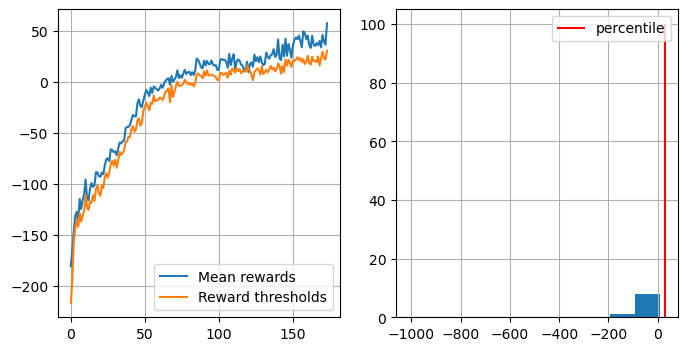

Time: 3008.527931690216
Win!
Time: 3008.5289318561554


In [27]:
n_sessions = 100
NeedMeanReward = 50

number_of_iterations = 200

percentile = 30
log = []
startTime = time.time()

agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()[0]]*n_actions,range(n_actions));

def run():
    for i in range(number_of_iterations):
        #generate new sessions
        sessions = [generate_session(agent) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.fit(elite_states, elite_actions)

        show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

        print("Time:", time.time() - startTime)

        if(rewards_batch.mean() > NeedMeanReward):
            print("Win!")
            break

    print("Time:", time.time() - startTime)
    
run()

Нуу, стало получше, работает в 4 раза быстрее :)

## Попробуем ускорить

Step 1: Добавим <b>многопоточность</b>

In [13]:
from joblib import Parallel, delayed

mean reward = 53.316, threshold=36.655


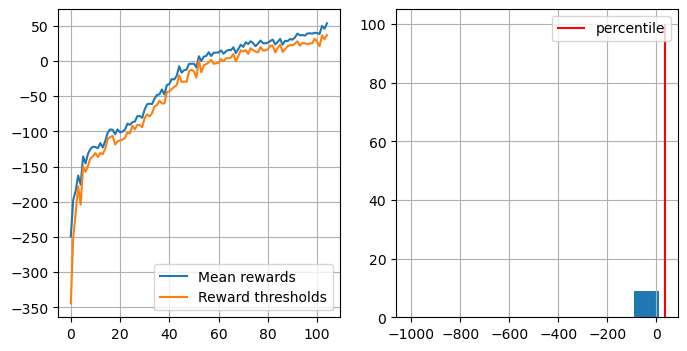

Time: 568.1636354923248
Win!
Time: 568.1636354923248


In [35]:
n_sessions = 100
NeedMeanReward = 50

number_of_iterations = 200

percentile = 30
log = []
startTime = time.time()

agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()[0]]*n_actions,range(n_actions));

def run():
    for i in range(number_of_iterations):
        #generate new sessions
        sessions = Parallel(n_jobs=-2)(delayed(generate_session)(agent) for _ in range(n_sessions))

        states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.fit(elite_states, elite_actions)

        show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

        print("Time:", time.time() - startTime)

        if(rewards_batch.mean() > NeedMeanReward):
            print("Win!")
            break

    print("Time:", time.time() - startTime)
    
run()

Ускорилось примерно в 5 раз, что неплохо

## Reusing 3-5 last iterations for training and thresholds.

Step 2: Попробуем переиспользовать последние 3 итерации для обучения.

mean reward = 50.497, threshold=30.337


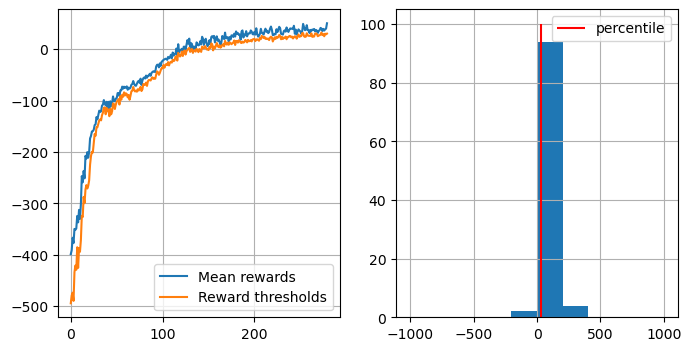

Time: 670.6223239898682
Win!
Time: 670.6223239898682


In [56]:
last_iterations = 3
n_sessions = 100
NeedMeanReward = 50

number_of_iterations = 1000

percentile = 30
log = []
startTime = time.time()

agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()[0]]*n_actions,range(n_actions));

All_states = []
All_actions = []
All_rewards = []

for i in range(number_of_iterations):
    sessions = Parallel(n_jobs=-2)(delayed(generate_session)(agent) for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))
    
    All_states.append(states_batch)
    All_actions.append(actions_batch)
    All_rewards.append(rewards_batch)

    rewards_batch = np.array(rewards_batch)
    
    A = []
    B = []
    C = []
    
    for i in range(len(All_states)):
        for v in All_states[i]:
            A.append(v)
        for v in All_actions[i]:
            B.append(v)
        for v in All_rewards[i]:
            C.append(v)
    
    elite_states, elite_actions = select_elites(A, B, np.array(C), percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log)

    print("Time:", time.time() - startTime)

    if(rewards_batch.mean() > NeedMeanReward):
        print("Win!")
        break
        
    if i >= last_iterations:
        del All_states[0]
        del All_actions[0]
        del All_rewards[0]

print("Time:", time.time() - startTime)
    


Можно заметить, что график стал более плавным, и запоминание последних 3-5 итераций помогает модели учиться и на старых ошибках. Но по времени этот метод работает примерно также как и без запоминания последних итераций.

Step 3: Посмотрим, как наша модель будет обучаться при разных training_iterations и learning_rate

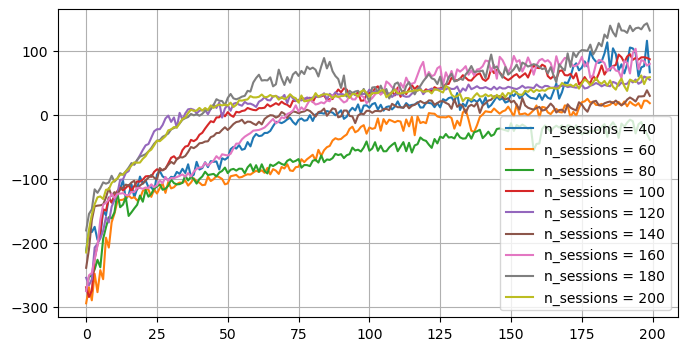

Time: 3896.45783495903


In [73]:
training_sessions = [i for i in range(40, 201, 20)]
learning_rates = [0.01, 0.03, 0.05, 0.075, 0.1, 0.2, 0.3]
percentile = 40

number_of_iterations = 200

def show_progress_iterations(mean, itr):
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(mean)):
        plt.plot(mean[i], label="n_sessions = " + str(itr[i]))
    plt.legend()
    plt.grid()
    
    plt.show()

mean = []
itr = []
    
for n_sessions in training_sessions:
    itr.append(n_sessions)
    log = []
    curMean = []
    startTime = time.time()
    agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                          activation='tanh',
                          warm_start=True, #keep progress between .fit(...) calls
                          max_iter=1 #make only 1 iteration on each .fit(...)
                         )
    agent.fit([env.reset()[0]]*n_actions,range(n_actions));

    for i in range(number_of_iterations):
        #generate new sessions
        sessions = Parallel(n_jobs=-2)(delayed(generate_session)(agent) for _ in range(n_sessions))

        states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.fit(elite_states, elite_actions)
        
        curMean.append(np.mean(rewards_batch))

        mean.append(curMean)
        
        show_progress_iterations(mean, itr)
        
        mean.pop()

        print("Time:", time.time() - startTime)
        
    mean.append(curMean)
        
    show_progress_iterations(mean, itr)

print("Time:", time.time() - startTime)

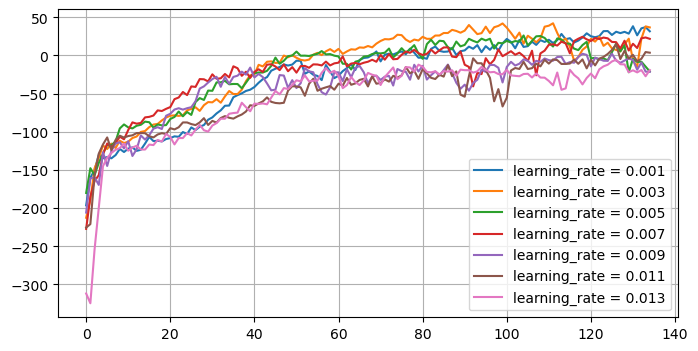

In [31]:
import time

learning_rates = [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013]
number_of_iterations = 135
percentile = 40

def show_progress_learning_rate(mean, rates):
    clear_output(True)
    plt.figure(figsize=[8,4])
    for i in range(len(mean)):
        plt.plot(mean[i], label="learning_rate = " + str(rates[i]))
    plt.legend()
    plt.grid()
    
    plt.show()

mean = []
rates = []

n_sessions = 100
    
for l_rate in learning_rates:
    rates.append(l_rate)
    curMean = []
    startTime = time.time()
    agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                          activation='tanh',
                          warm_start=True, #keep progress between .fit(...) calls
                          max_iter=1, #make only 1 iteration on each .fit(...)
                          learning_rate_init = l_rate,
                         )
    agent.fit([env.reset()[0]]*n_actions,range(n_actions));

    for i in range(number_of_iterations):
        #generate new sessions
        
        sessions = Parallel(n_jobs=-2)(delayed(generate_session)(agent) for _ in range(n_sessions))

        states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        agent.fit(elite_states, elite_actions)
        curMean.append(np.mean(rewards_batch))

        mean.append(curMean)
        
        show_progress_learning_rate(mean, rates)
        
        print(time.time() - startTime)
        
        mean.pop()

    mean.append(curMean)
        
    show_progress_learning_rate(mean, rates)


# Немного визуализации

Посмотрим, как наша модель справляется с посадкой, когда ее средняя награда будет больше 100.

mean reward = 104.393, threshold=187.374


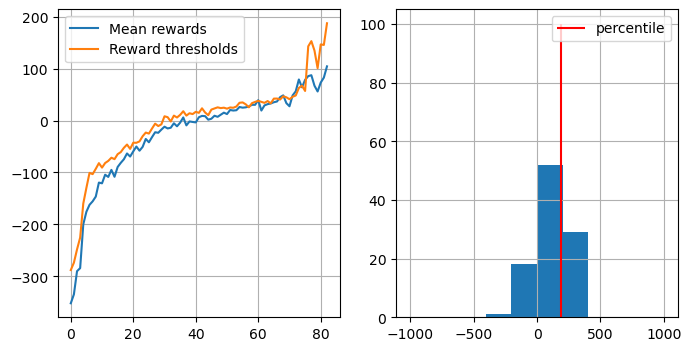

Time: 598.7347526550293
Win!
Time: 598.735298871994


In [38]:
# сделаем модель, у которой средняя награда больше 100

n_sessions = 100
NeedMeanReward = 100

number_of_iterations = 1000

percentile = 60
log = []
startTime = time.time()

agent = MLPClassifier(hidden_layer_sizes=(20, 20, 8), #(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()[0]]*n_actions,range(n_actions));

for i in range(number_of_iterations):
    #generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent) for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

    rewards_batch = np.array(rewards_batch)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log)

    print("Time:", time.time() - startTime)

    if(rewards_batch.mean() > NeedMeanReward):
        print("Win!")
        break

print("Time:", time.time() - startTime)

In [39]:
visualize(agent, t_max=500)

C:\Users\vinik\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Report


Изначально модель, чтобы достигнуть средней награды больше 50 обучалась очень долго (3.3 часа).
Затем после изменения некоторых параметров, модель без многопоточности обучилась в 4 раза быстрее.

Многопоточность (joblib) ускорила обучение в 5-6 раз, и модель уже хорошо обучалась. Запоминание последних 3-5 итераций сделало график обучения более плавным, в сравнении с графиком без запоминания.

В среднем почти для каждого n_sessions модель достигала средней награды больше 50. Иногда удавалось больше 100. Но n_sessions не очень сильно коллерируют между собой.

Между различными learning_rate я корреляции тоже не заметил, но в связи с чем-то все они не достигли награды больше 50. Видимо MLP Classifier более умно настраивает learning_rate, потому что в среднем за такое же количество итераций модель лучше обучалась. Я сделал ограничение на 135 итераций, потому что график считался очень долго. (Для n_sessions он считался 6 часов примерно, а для learning_rate ~3.5 часа)

Ну и интересно смотреть, как обученная модель ведет себя в реальной игре при визуализации, а не просто на графиках.